In [1]:
import numpy as np
from pylab import *
import os
from scipy.interpolate import interp1d
from scipy.integrate import quad
import matplotlib.pylab as plt
import pandas as pd
from astropy.io import fits
from astropy.wcs import WCS

import cerrado #my own plot library- not really necessary
from hsc_utils import map_utils as mu  #Some handy codes for this project

In [2]:
######### here are the weights for each source redshift to match HSC pz

zs_tng = array([0.034, 0.07 , 0.105, 0.142, 0.179, 0.216, 0.255, 0.294, 0.335,
       0.376, 0.418, 0.462, 0.506, 0.552, 0.599, 0.648, 0.698, 0.749,
       0.803, 0.858, 0.914, 0.973, 1.034, 1.097, 1.163, 1.231, 1.302,
       1.375, 1.452, 1.532, 1.615, 1.703, 1.794, 1.889, 1.989, 2.094,
       2.203, 2.319, 2.44 , 2.568])
 

# Read HSC pz- real data and take pz(zs_tng):

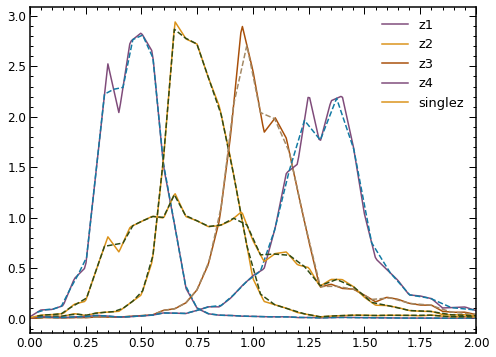

In [3]:
import cerrado
cerrado.set_color_cycle('flores_II')


zs = ['z1','z2','z3','z4' ,'singlez']
plt.figure()
for zz in zs:
    z_, pz_ = np.load('/home/gabriela/Documents/Pesquisa/NG_project/data/real_data/pz/pz_allfields_normalized_'+zz+'.npy')
    pz_f = interp1d(z_, pz_, fill_value="extrapolate")
    pz_modif = pz_f(zs_tng)
    pz_modif[pz_modif<0]=0
    
    plt.plot(z_, pz_ ,label=zz)
    plt.legend()
    plt.xlim(0,2.)
    plt.plot(zs_tng, pz_modif,'--' )
    
    np.save('/home/gabriela/Documents/Pesquisa/NG_project/data/for_baryons/weights_pz/pz_'+zz+'_zstng_normed.npy',pz_modif)

# $N_{\rm{eff}}$ :

#Heymans et al. (2012) definition:

I. $n_{eff} = \frac{1}{\Omega_{sky}} \frac{(\sum_{i}w_{i})^2}{\sum_{i}w_{i}^2}$ 

#Chang et al. (2013) definition:


II. $n_{eff} = \frac{1}{\Omega_{sky}} \sum_{i}\frac{e^2_{rms}}{\sigma_{e,i}^2+e^2_{rms,i}}$ 


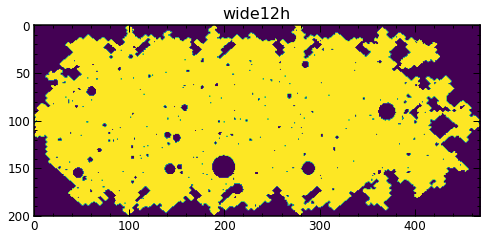

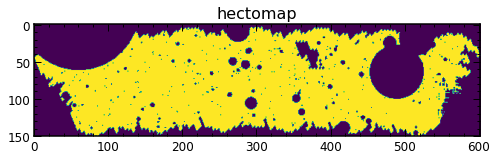

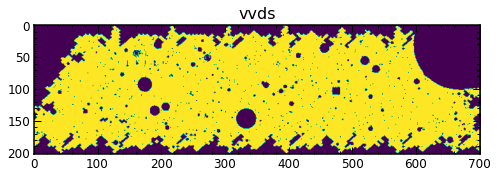

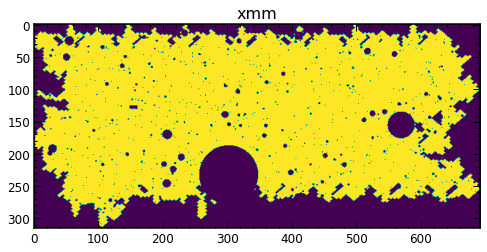

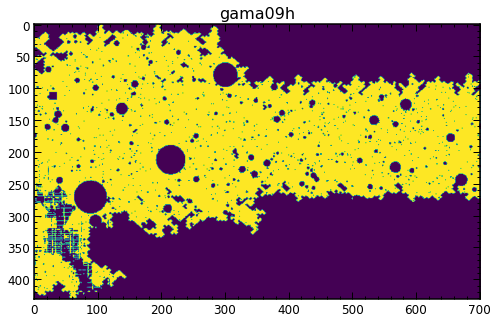

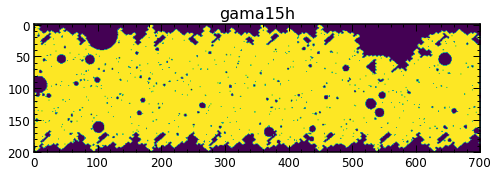

5.383928799072861  ---ng usual
-------z1-------
Neff according to Heymans et al. 2012, neff=5.14 /arcmin^2
Neff according to Chang et al. 2013, neff=4.92 /arcmin^2
---------------------------------
5.474406206433626  ---ng usual
-------z2-------
Neff according to Heymans et al. 2012, neff=5.23 /arcmin^2
Neff according to Chang et al. 2013, neff=4.93 /arcmin^2
---------------------------------
4.119681993119215  ---ng usual
-------z3-------
Neff according to Heymans et al. 2012, neff=3.99 /arcmin^2
Neff according to Chang et al. 2013, neff=3.61 /arcmin^2
---------------------------------
2.3825392892686756  ---ng usual
-------z4-------
Neff according to Heymans et al. 2012, neff=2.33 /arcmin^2
Neff according to Chang et al. 2013, neff=2.00 /arcmin^2
---------------------------------
17.36055628789438  ---ng usual
-------singlez-------
Neff according to Heymans et al. 2012, neff=16.62 /arcmin^2
Neff according to Chang et al. 2013, neff=15.45 /arcmin^2
---------------------------------


In [4]:
names_files = ['wide12h','hectomap','vvds','xmm','gama09h','gama15h']
path_data =  '/home/gabriela/Documents/Pesquisa/NG_project/data/real_data/real_data_after_match_and_separate/'
mask_path = '/home/gabriela/Documents/Pesquisa/NG_project/data/real_data/maps/'




total_area = 0
for nn in names_files:
    #Read mask to get area:
    mask, wcs = mu.read_fits(mask_path+'mask_based_weights_'+nn+'.fits')

    plt.figure()
    plt.imshow(mask ,cmap='viridis')
    plt.title(nn)
    plt.show()

    shape = np.shape(mask.T)
    flat_obj = mu.FlatClass(wcs, nx= shape[0], ny= shape[1])

    area_pix = np.radians(flat_obj.dx)*np.radians(flat_obj.dy)*(180./np.pi)**2.
    area_sqdeg = np.sum(mask)*area_pix
#     print(area_sqdeg, 'area sq of the field'+ nn)
    total_area = total_area+ area_sqdeg
    

         
        
for zz in zs:
    w_total = np.array([])
    erms_total = np.array([])
    sigma_total = np.array([])
    for nn in names_files:
        #Read real data:
        cat = pd.read_csv(path_data+nn+'_'+zz+'.csv' )
        
        w_total  = np.concatenate([w_total , np.array(cat['ishape_hsm_regauss_derived_shape_weight'])])
        erms_total  = np.concatenate([erms_total , np.array(cat['ishape_hsm_regauss_derived_rms_e'])])
        sigma_total = np.concatenate([sigma_total , np.array(cat['ishape_hsm_regauss_derived_sigma_e'])])


    print(len(w_total)/(total_area*60*60), ' ---ng usual' )

    #Heymans et al. (2012) definition:
    wratio = np.sum(w_total)**2/np.sum(w_total**2)
    neff = (wratio/(total_area*60*60))
    print('-------'+zz+'-------')
    print ('Neff according to Heymans et al. 2012, neff=%.2f /arcmin^2'%(neff))

    #Chang et al. (2013) definition:
    factor  = np.sum(erms_total**2/(erms_total**2+sigma_total**2))
    neff_chang = (factor/(total_area*60*60))
    print ('Neff according to Chang et al. 2013, neff=%.2f /arcmin^2'%(neff_chang))
    print('---------------------------------')
    
    np.save('/home/gabriela/Documents/Pesquisa/NG_project/data/for_baryons/neff/neff_Heymans2012_'+zz+'.npy',neff )